In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
from datetime import date
import operator 
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy import integrate, optimize
#from covidmx import CovidMX
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [4]:
##MOdelos
def exponential_model(x,a,b):
    return (a/b)*(np.exp(x*b)-1)

def gompertz_model(x,g):
    return k*np.exp(-n0*np.exp(-g*x))

def gompertz_hubbert(x,g):
    return g*n0*np.exp(-g*x)*k*np.exp(-n0*np.exp(-g*x))

def logistic_model(x,r,C0,K):
    return K/(1+((K-C0)/C0)*np.exp(-r*x))

def hubbert_curve(x,r,C0,K):
    return (np.exp(r*x)*r*C0*(K-C0))/(K*(1+C0/K *(np.exp(r*x) -1))**2)

In [5]:
def SIQR_COVID(y,t,beta,alpha,eta):
    S, I, Q, R = y
    dSdt = -beta*S*I/N 
    dIdt = beta*S*I/N - (alpha+ eta)*I
    dQdt = eta*I - gamma*Q
    dRdt = gamma*Q+alpha*I
    return dSdt, dIdt, dQdt, dRdt
def fit_odeint_1(x,beta,alpha,eta):
    return integrate.odeint(SIQR_COVID,(S0,I0,Q0,R0),x,args=(beta,alpha,eta))[:,1]
def fit_odeint1_1(x,beta,alpha,eta):
    return integrate.odeint(SIQR_COVID,(S01,I01,Q01,R01),x,args=(beta,alpha,eta))[:,1]

In [6]:
DatosMexico=pd.read_csv('C:\\Users\\shada\\Documents\\Covid\\datosmexico.csv',index_col=0)
DatosMichoacan=pd.read_csv('C:\\Users\\shada\\Documents\\Covid\\datosmichoacan.csv',index_col=0)

In [26]:
def modelos_plot(df,inicio, final,parametros,country):
    df=df[inicio:final]
    fecha=df.index[0]
    y1 = list(df.loc[:,'Acumulados'])
    x= list(range(0,len(y1)))
    par2,cov2=curve_fit(exponential_model,x,y1,[32,0.05])
    #parametros
    N=parametros[0]
    gamma=parametros[1]
    delta=parametros[2]
    I0=parametros[3]
    eta=delta*0.2
    alpha = par2[0]/I0 -eta
    beta = par2[1] + alpha+eta
    R0, Q0 = 0, 0
    S0 = N - I0 - R0 - Q0
    y0 = S0, I0, Q0, R0
    
    t = np.linspace(0, 250,251)
    #
    ret = integrate.odeint(SIQR_COVID, y0, t, args=(beta,alpha,eta))
    S, I, Q, R = ret.T
    H=Q+R
    time1 = pd.date_range(start=fecha, periods=len(y1))
    #time1=time1.strftime('%d-%m')
    time2=pd.date_range(start=fecha, periods=251)
    time3=pd.date_range(start=fecha, end=final)
    #time2=time2.strftime('%d-%m')
    print("Optimal parameters: a =", par2[0], "  b = ", par2[1], "I/Q = ", (gamma + beta -alpha-eta)/eta, "beta= ", beta,"alpha= ", alpha,"gamma= ", gamma  )
    
    
    plt.figure(figsize=(16, 9))
    plt.scatter(time1, y1,label='Casos Confirmados',color='black',zorder=10)
    #plt.scatter(time1,y1,color="black")
    plt.plot(time2, Q+R,color='red',label='Q+R')
    plt.plot(time2, Q,color='blue',label='Q')
    plt.plot(time2, I,color='green',label='Infectados SIQR')
    plt.title('Modelo SIQR para {}'.format(country), size=30)
    plt.xlabel('Días desde {}'.format(time1[0].strftime('%d-%m-%Y')), size=30)
    plt.ylabel('# de Casos', size=30)
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().set_xlim(time1[0], time2[-1]+datetime.timedelta(days=8))
    #plt.gca().set_ylim(0, y_acum3[-1]+10000)
    plt.xticks(size=20)
    #plt.xticks(rotation=45)
    plt.yticks(size=20)   
    legend = plt.legend()
    #plt.savefig("E:\\Graficas\\SIQRExpo{}-1.pdf".format(country), dpi=300, bbox_inches='tight')
    plt.show()

    
    plt.figure(figsize=(16, 9))
    plt.scatter(time1, y1,label='Casos Confirmados',color='black',zorder=10)
    #plt.scatter(time1,y1,color="black")
    plt.plot(time2[:50], H[:50],color='red',label='Q+R')
    #plt.plot(time2[:50], Q[:50],color='b',label='Q')
   #plt.plot(time2[:50], R[:50],color='g',label='R')
    plt.title('Modelo SIQR para {}'.format(country), size=30)
    plt.xlabel('Días desde {}'.format(time1[0].strftime('%d-%m-%Y')), size=30)
    plt.ylabel('# de Casos', size=30)
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().set_xlim(time1[0], time2[50]+datetime.timedelta(days=8))
    #plt.gca().set_ylim(0, y_acum3[-1]+10000)
    plt.xticks(size=20)
    #plt.xticks(rotation=45)
    plt.yticks(size=20)   
    legend = plt.legend()
    #plt.savefig("E:\\Graficas\\SIQRExpo{}-1.pdf".format(country), dpi=300, bbox_inches='tight')
    plt.show()   
    
    
    return len(y1), len(H[:50])

Optimal parameters: a = 30.898410713817587   b =  0.07887163598346357 I/Q =  4.629054532782115 beta=  3.941172975210662 alpha=  3.8323013392271985 gamma=  0.06


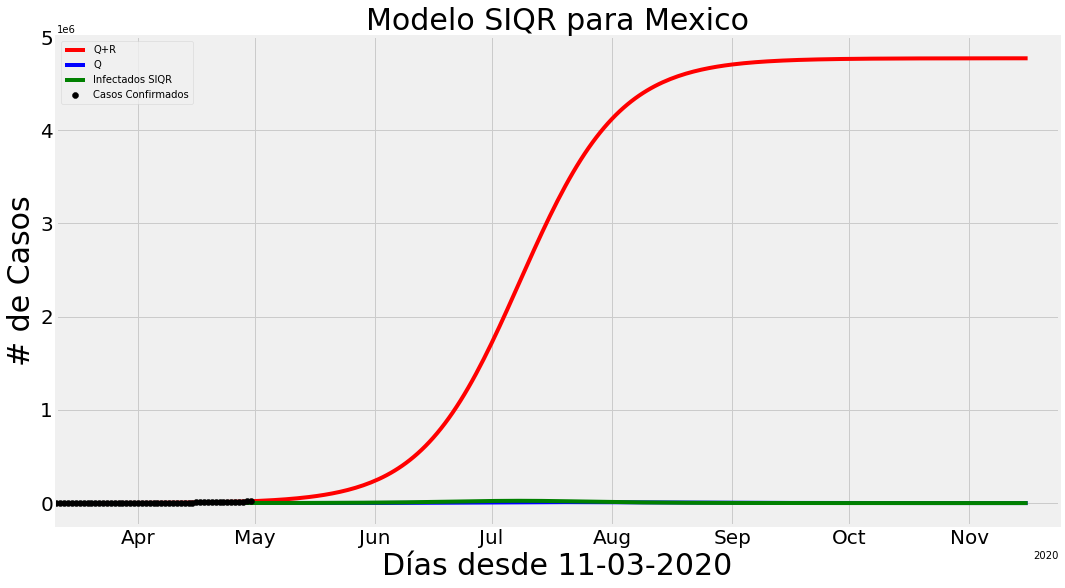

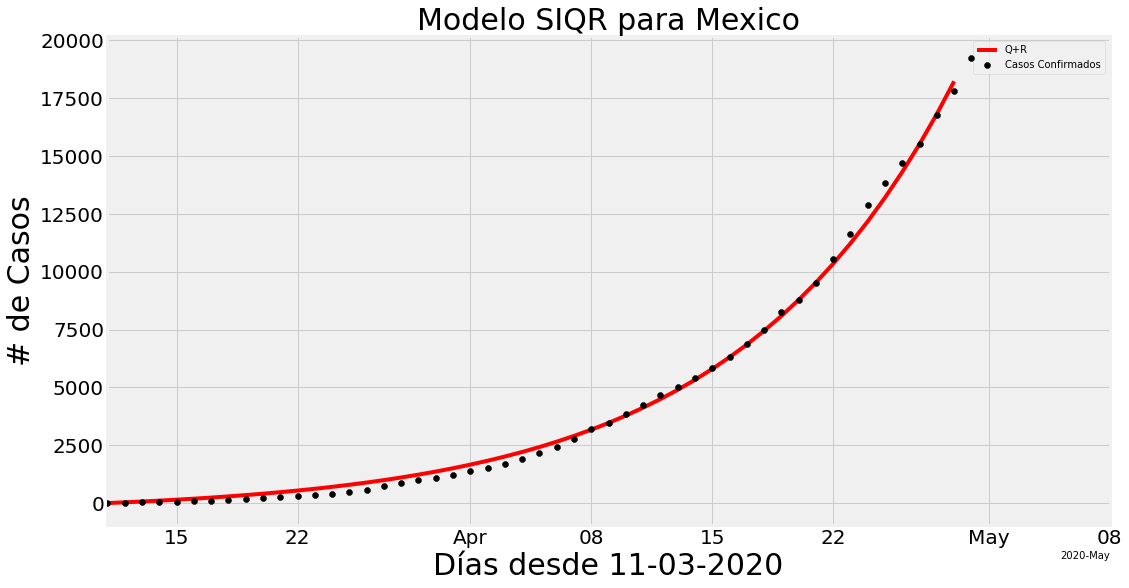

(51, 50)

In [27]:
#Mexico
gamma=0.06
N=120000000
parametros= 120000000,0.06, 0.15, 8
modelos_plot(DatosMexico,'2020-03-11','2020-04-30',parametros,'Mexico')


Optimal parameters: a = 2.2767860040811434   b =  0.06275806220146614 I/Q =  4.091935406715536 beta=  0.25249022920822806 alpha=  0.15973216700676196 gamma=  0.06


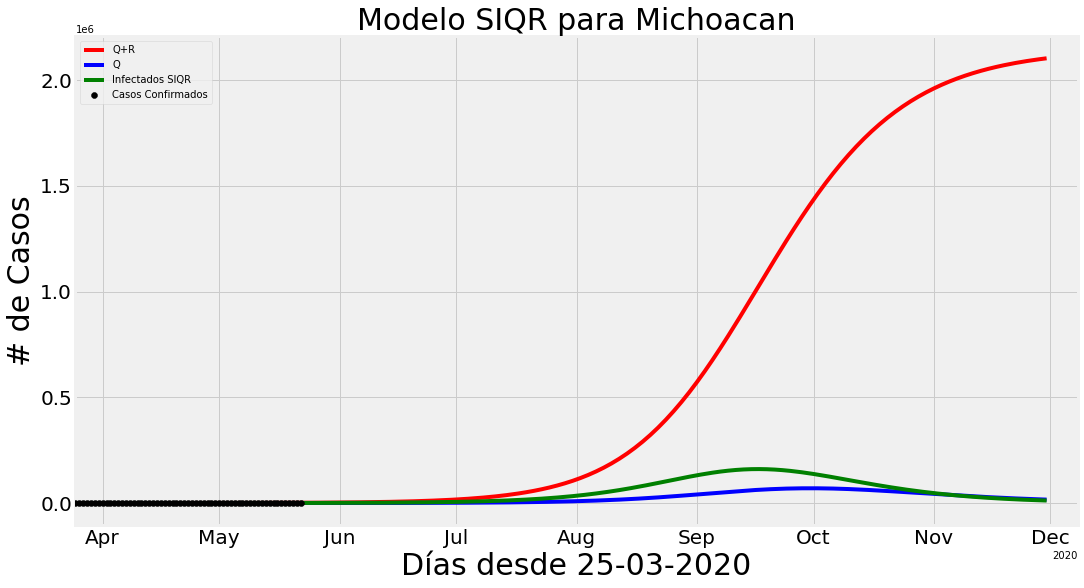

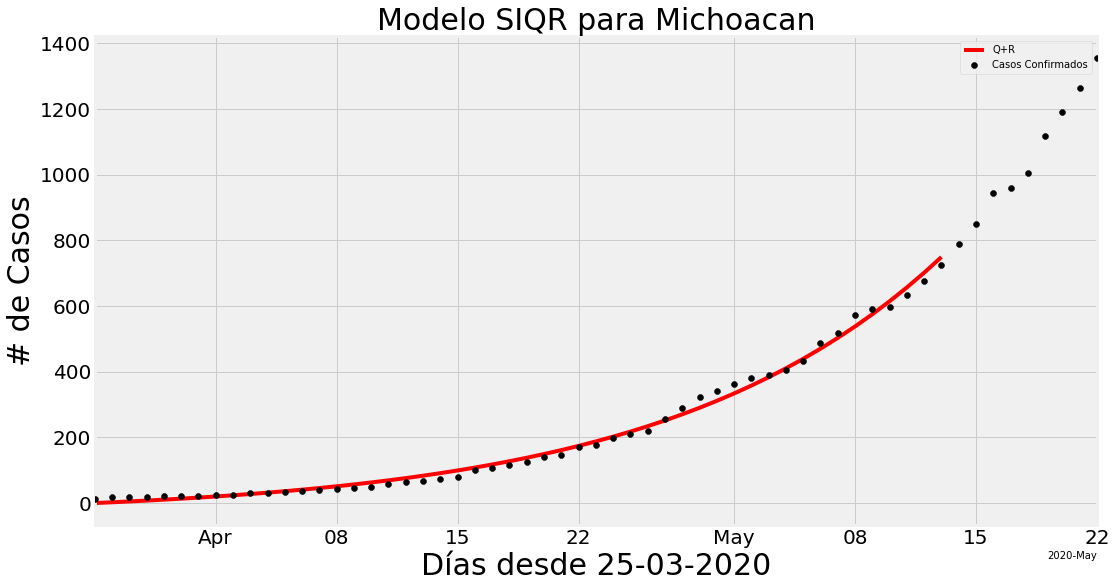

(59, 50)

In [28]:
#Michoacan
gamma=0.06
N=4749000
parametros= 4749000,0.06, 0.15, 12
modelos_plot(DatosMichoacan,'2020-03-25','2020-05-22',parametros,'Michoacan')

In [24]:
DatosMichoacan

,Nuevos,Acumulados,Recuperados,Activos
2020-03-21,4,4,0,4
2020-03-22,4,8,0,8
2020-03-23,2,10,0,10
2020-03-24,1,11,0,11
2020-03-25,1,12,0,12
...,...,...,...,...
2021-09-17,495,107322,98519,8803
2021-09-18,467,107789,99186,8603
2021-09-19,439,108228,99826,8402
2021-09-20,450,108678,100494,8184
